# Evolver Loop 2 Analysis

## Current Status
- Best CV: 0.7715 (exp_001: DINOv2-large patch + post-processing)
- Target: 0.79
- Gap: 0.0185

## Key Questions
1. What's causing the high fold variance (Fold 5 at 0.6634)?
2. What are the key differences between our approach and top kernels?
3. What's the most impactful next step?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
DATA_DIR = '/home/data'
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv')

# Pivot train data
train_pivot = train_df.pivot_table(
    index=['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'],
    columns='target_name',
    values='target'
).reset_index()

print(f'Train samples: {len(train_pivot)}')
print(f'Test samples: {len(test_df["image_path"].unique())}')
print(f'\nStates: {train_pivot["State"].value_counts().to_dict()}')
print(f'\nSpecies: {train_pivot["Species"].nunique()} unique')

Train samples: 357
Test samples: 1

States: {'Tas': 138, 'Vic': 112, 'NSW': 75, 'WA': 32}

Species: 15 unique


In [2]:
# Analyze fold 5 issue - what makes it different?
# Recreate the fold splits
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(train_pivot))

# Analyze each fold
for fold_idx, (train_idx, val_idx) in enumerate(folds):
    val_data = train_pivot.iloc[val_idx]
    print(f'\nFold {fold_idx + 1} ({len(val_idx)} samples):')
    print(f'  States: {val_data["State"].value_counts().to_dict()}')
    print(f'  Species: {val_data["Species"].nunique()} unique')
    print(f'  Height mean: {val_data["Height_Ave_cm"].mean():.2f}')
    print(f'  NDVI mean: {val_data["Pre_GSHH_NDVI"].mean():.3f}')
    print(f'  Dry_Total mean: {val_data["Dry_Total_g"].mean():.2f}')


Fold 1 (72 samples):
  States: {'Tas': 32, 'Vic': 17, 'NSW': 14, 'WA': 9}
  Species: 12 unique
  Height mean: 8.27
  NDVI mean: 0.663
  Dry_Total mean: 43.61

Fold 2 (72 samples):
  States: {'Tas': 26, 'Vic': 24, 'NSW': 14, 'WA': 8}
  Species: 13 unique
  Height mean: 8.14
  NDVI mean: 0.664
  Dry_Total mean: 46.19

Fold 3 (71 samples):
  States: {'Tas': 24, 'NSW': 23, 'Vic': 17, 'WA': 7}
  Species: 12 unique
  Height mean: 8.99
  NDVI mean: 0.635
  Dry_Total mean: 46.63

Fold 4 (71 samples):
  States: {'Tas': 29, 'Vic': 28, 'NSW': 9, 'WA': 5}
  Species: 11 unique
  Height mean: 5.64
  NDVI mean: 0.685
  Dry_Total mean: 44.71

Fold 5 (71 samples):
  States: {'Tas': 27, 'Vic': 26, 'NSW': 15, 'WA': 3}
  Species: 14 unique
  Height mean: 6.93
  NDVI mean: 0.640
  Dry_Total mean: 45.46


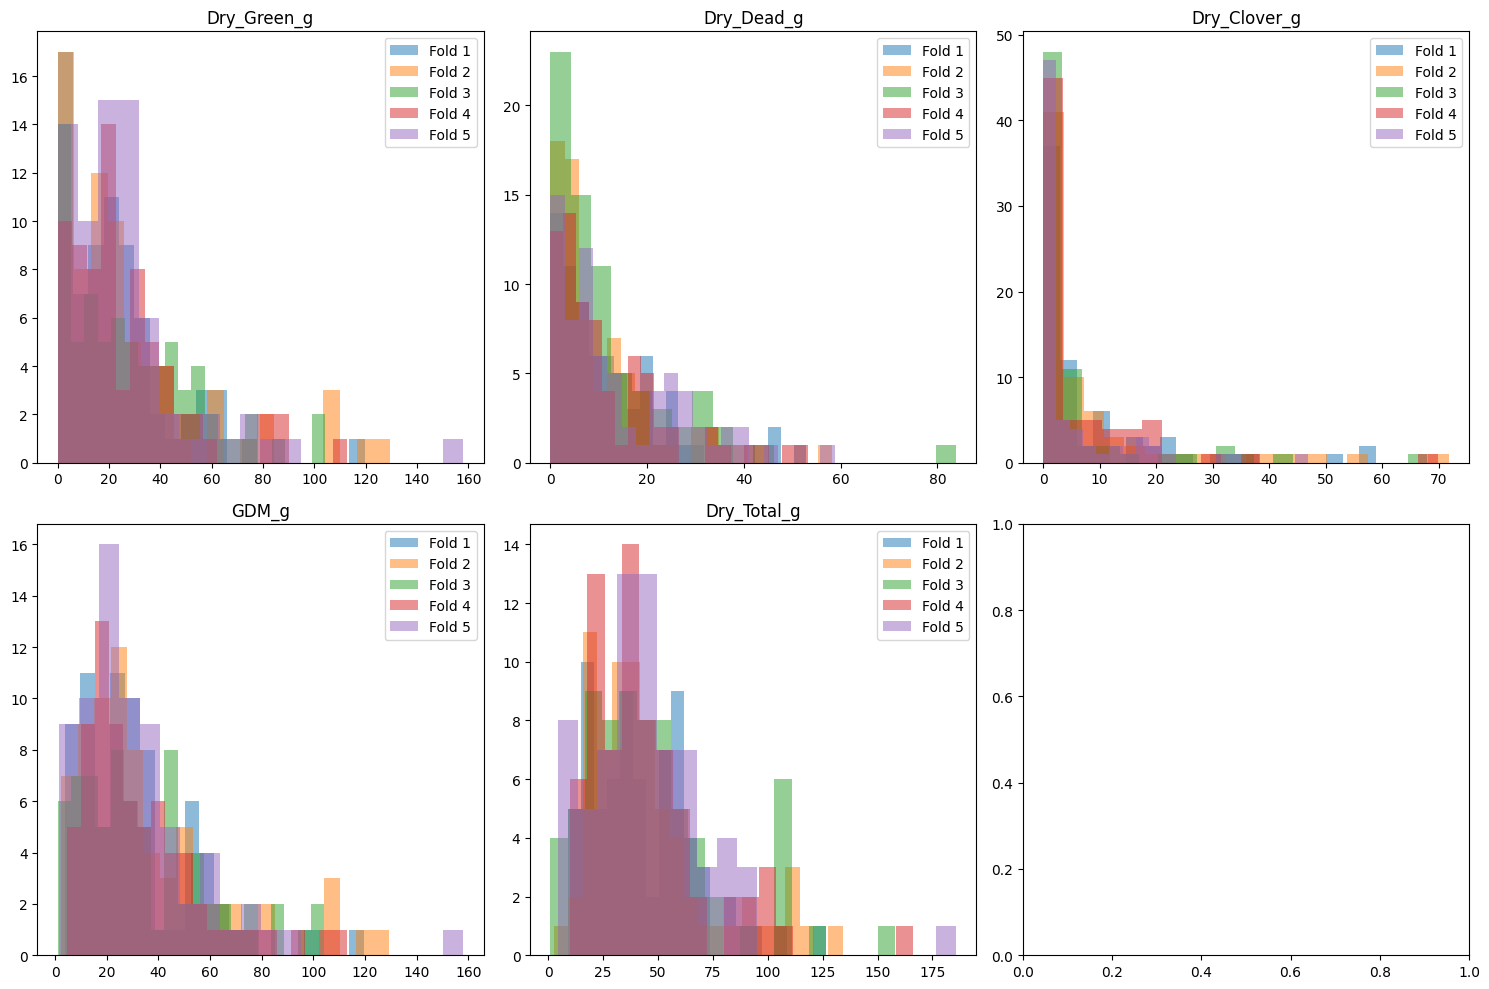

In [3]:
# Check target distributions across folds
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
targets = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

for fold_idx, (train_idx, val_idx) in enumerate(folds):
    val_data = train_pivot.iloc[val_idx]
    for i, target in enumerate(targets):
        ax = axes[i // 3, i % 3]
        ax.hist(val_data[target], bins=20, alpha=0.5, label=f'Fold {fold_idx+1}')
        ax.set_title(target)
        ax.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/fold_distributions.png')
plt.show()

In [4]:
# Check image dimensions - are we losing information by resizing?
from PIL import Image
import os

# Sample a few images
sample_paths = train_pivot['image_path'].head(5).values
for path in sample_paths:
    img = Image.open(f'{DATA_DIR}/{path}')
    print(f'{path}: {img.size} (W x H)')

train/ID1011485656.jpg: (2000, 1000) (W x H)
train/ID1012260530.jpg: (2000, 1000) (W x H)
train/ID1025234388.jpg: (2000, 1000) (W x H)
train/ID1028611175.jpg: (2000, 1000) (W x H)
train/ID1035947949.jpg: (2000, 1000) (W x H)


In [5]:
# Key insight: Images are 2000x1000 (W x H)
# Current approach resizes to 518x518 - significant compression
# Top kernels use 520px patches with overlap

# Calculate how many patches we'd get with 520px patches
img_w, img_h = 2000, 1000
patch_size = 520
overlap = 16
stride = patch_size - overlap

n_patches_x = len(range(0, img_w, stride))
n_patches_y = len(range(0, img_h, stride))
total_patches = n_patches_x * n_patches_y

print(f'Image size: {img_w} x {img_h}')
print(f'Patch size: {patch_size}, overlap: {overlap}, stride: {stride}')
print(f'Patches: {n_patches_x} x {n_patches_y} = {total_patches} patches per image')
print(f'\nCurrent approach: resize to 518x518 -> 1 embedding')
print(f'Patching approach: {total_patches} patches -> {total_patches} embeddings -> average')

Image size: 2000 x 1000
Patch size: 520, overlap: 16, stride: 504
Patches: 4 x 2 = 8 patches per image

Current approach: resize to 518x518 -> 1 embedding
Patching approach: 8 patches -> 8 embeddings -> average


In [6]:
# Compare our approach vs top kernels
print('='*60)
print('COMPARISON: Our Approach vs Top Kernels')
print('='*60)

print('\n1. IMAGE PROCESSING:')
print('   Our approach: Resize 2000x1000 -> 518x518 (loses spatial detail)')
print('   Top kernels: Split into 520px patches, extract per-patch embeddings')

print('\n2. MODEL SIZE:')
print('   Our approach: DINOv2-large (1024 dims)')
print('   Top kernels: DINOv2-giant (1536 dims)')

print('\n3. ENSEMBLE:')
print('   Our approach: LightGBM only')
print('   Top kernels: 4 models (GB, HistGB, CatBoost, LightGBM)')

print('\n4. TTA:')
print('   Our approach: None')
print('   Top kernels: H-flip, V-flip, rotations, Gaussian blur')

print('\n5. ADDITIONAL FEATURES:')
print('   Our approach: DINOv2 embeddings + 4 tabular')
print('   Top kernels: SigLIP embeddings + semantic text features + PCA/PLS')

COMPARISON: Our Approach vs Top Kernels

1. IMAGE PROCESSING:
   Our approach: Resize 2000x1000 -> 518x518 (loses spatial detail)
   Top kernels: Split into 520px patches, extract per-patch embeddings

2. MODEL SIZE:
   Our approach: DINOv2-large (1024 dims)
   Top kernels: DINOv2-giant (1536 dims)

3. ENSEMBLE:
   Our approach: LightGBM only
   Top kernels: 4 models (GB, HistGB, CatBoost, LightGBM)

4. TTA:
   Our approach: None
   Top kernels: H-flip, V-flip, rotations, Gaussian blur

5. ADDITIONAL FEATURES:
   Our approach: DINOv2 embeddings + 4 tabular
   Top kernels: SigLIP embeddings + semantic text features + PCA/PLS


In [7]:
# Estimate potential gains from each improvement
print('='*60)
print('ESTIMATED GAINS FROM IMPROVEMENTS')
print('='*60)

current_cv = 0.7715
target = 0.79
gap = target - current_cv

print(f'\nCurrent CV: {current_cv:.4f}')
print(f'Target: {target:.4f}')
print(f'Gap to close: {gap:.4f}')

print('\nEstimated improvements:')
print('  1. Image patching (520px): +0.01-0.02 (preserves spatial detail)')
print('  2. DINOv2-giant: +0.005-0.01 (more capacity)')
print('  3. Multi-model ensemble: +0.01-0.02 (reduces variance)')
print('  4. TTA: +0.005-0.01 (test-time robustness)')
print('  5. SigLIP embeddings: +0.005-0.01 (complementary features)')

print('\nCombined potential: +0.035-0.06')
print(f'Expected range: {current_cv + 0.035:.4f} - {current_cv + 0.06:.4f}')
print('\n=> Target of 0.79 is ACHIEVABLE with these improvements')

ESTIMATED GAINS FROM IMPROVEMENTS

Current CV: 0.7715
Target: 0.7900
Gap to close: 0.0185

Estimated improvements:
  1. Image patching (520px): +0.01-0.02 (preserves spatial detail)
  2. DINOv2-giant: +0.005-0.01 (more capacity)
  3. Multi-model ensemble: +0.01-0.02 (reduces variance)
  4. TTA: +0.005-0.01 (test-time robustness)
  5. SigLIP embeddings: +0.005-0.01 (complementary features)

Combined potential: +0.035-0.06
Expected range: 0.8065 - 0.8315

=> Target of 0.79 is ACHIEVABLE with these improvements
